## Comparative analysis for the baseline fitting of denatured and folded protein

In this notebook we fit the unfolded baseline to completly unfolded curves based on a temperature window of a set size from the high end of temperatures for curves of 330nm and 350nm. We compare two baseline fitting formulas, quadratic and exponential, and compare them for their ability to generalize to the whole curve. 

### Using the demo DSF data forevaluation of the two formulas

In [1]:
#imports for the plotting of pychemelt

import matplotlib.pyplot as plt
import numpy as np

from pychemelt import Sample


def model(x, a, b, c=None, kind=None):
    """
    Encoding functions for baseline fitting
    """
    if kind == "linear":
        return a + x * b
    elif kind == "quadratic":
        return a + b*x + c*(x**2)
    elif kind == "exponential":
        return a + b * np.exp(-c * x)
    else:
        raise ValueError("Unknown model type")
    

def rmse(x1, x2):
    """
    Implementation of RMSE
    """
    return np.sqrt(np.mean((x1 - x2)**2))


#okabe ito colorblind friendly colorscheme
okabe_ito = {
    "black":       "#000000",
    "orange":      "#E69F00",
    "skyblue":     "#56B4E9",
    "bluishgreen": "#009E73",
    "yellow":      "#F0E442",
    "blue":        "#0072B2",
    "vermillion":  "#D55E00",
    "reddishpurple": "#CC79A7",
}

### Using the demo baseline and 3 curves without inflection points as comparison

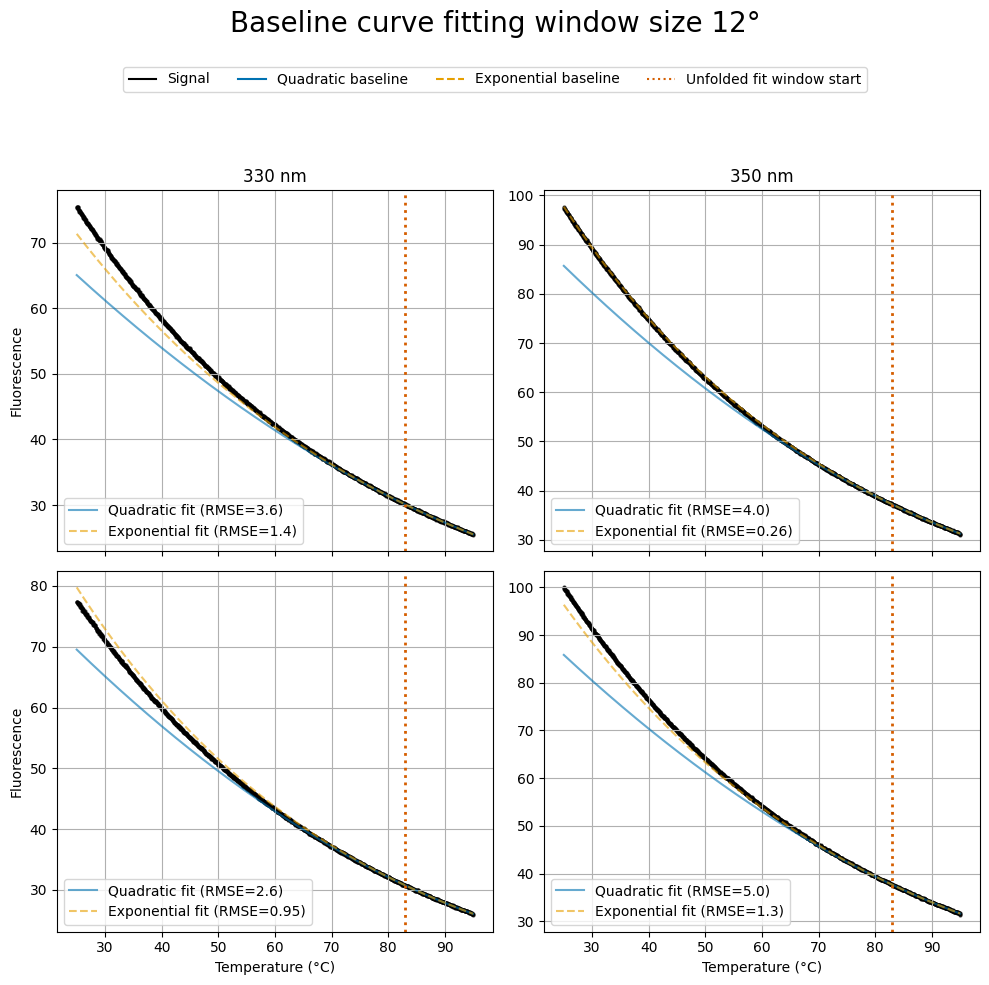

In [2]:


def unfolded_comp(conditions, filename="../data/nDSFdemoFile.xlsx", ws=12): 
    """
    Compare quadratic and exponential unfolded baseline fits for DSF data with unfolded curves.

    This function loads DSF fluorescence data using the pychemelts `Sample`
    interface, estimates unfolded-state baselines using both quadratic and
    exponential models by fitting the curves to the data of the last ws °C, 
    compares their performance using RMSE, and visualizes
    the results for two fluorescence signals (330 nm and 350 nm).

    Parameters
    ----------
    conditions : list of bool
        Boolean mask specifying which experimental conditions are selected
        for analysis. Length must match the number of experiments in the input
        dataset. Typically, `True` values correspond to curves without an
        inflection point used for unfolded baseline estimation.

    ws : int, optional, Default 12
        Window size (in °C) used for fitting the unfolded baseline.
        This parameter defines the temperature range over which the baseline
        parameters are estimated. Default is 12.

    Returns
    -------
    rmses: list
        The RMSE values of both baselines for all curves for both wavelengths.

    Notes
    -----
    - RMSE is computed between the measured fluorescence signal and the fitted
      baseline for each denaturant concentration and signal.
    - Temperatures are internally converted to Kelvin and referenced to 298 K
      before model evaluation.
    - A shared legend and figure-level title are used for visualization.

    Examples
    --------
    >>> conditions = (
    ...     [False] * 18
    ...     + [True] * 3
    ...     + [False] * (48 - 21)
    ... )
    >>> unfolded_comp(conditions, ws=12)
    """
        
    #using pychemelts sample structure for the loading of the data and prediction

    sample = Sample()
    sample.read_multiple_files(filename)
    sample.set_denaturant_concentrations()

    #usage of 330nm and 350nm for the initial curves
    sample.set_signal(["330nm", "350nm"])
    
    #experiments used for evaluation, should be curves without inflection 
    sample.select_conditions(conditions)    


    #fit the baselines as quadratic curve
    sample.estimate_baseline_parameters(
        native_baseline_type="linear",
        unfolded_baseline_type="quadratic",
        window_range_unfolded=ws
    )

    a_quas = sample.first_param_Us_per_signal
    b_quas = sample.second_param_Us_per_signal
    c_quas = sample.third_param_Us_per_signal

    #fit the baselines as exponential curve
    sample.estimate_baseline_parameters(
        native_baseline_type="linear",
        unfolded_baseline_type="exponential",
        window_range_unfolded=ws
    )

    a_exps = sample.first_param_Us_per_signal
    b_exps = sample.second_param_Us_per_signal
    c_exps = sample.third_param_Us_per_signal

    #assigning preprocessed signal and temperature for plotting
    temperature = sample.temp_lst_multiple[0][0]     
    fluorescences = sample.signal_lst_multiple  

    
    #using the removed reference temperature for plotting
    temperature_K = temperature + 273.15
    temperature_K_ref = temperature_K - 298

    #creating all formula results for comparison and plots

    fig, axes = plt.subplots(
    ncols=2,
    nrows=sample.nr_den,
    figsize=(10, 5 * sample.nr_den),
    sharex=True,
    )

    T_window_start = temperature.max() - ws

    for i in range(2):    # 330nm and 350nm

        for j in range(sample.nr_den):
            
            ax = axes[j, i]

            qua_bl = model(temperature_K_ref,
                a_quas[i][j],
                b_quas[i][j],
                c_quas[i][j],
                kind="quadratic")


            exp_bl = model(temperature_K_ref,
                a_exps[i][j],
                b_exps[i][j],
                c_exps[i][j],
                kind="exponential")



            #plotting the results
            ax.scatter(
                temperature,
                fluorescences[i][j],
                s=4,
                color=okabe_ito["black"],
                alpha=0.7,
            )

            ax.plot(
                temperature,
                qua_bl,
                color=okabe_ito["blue"],
                alpha=0.6,
                label=f"Quadratic fit (RMSE={rmse(fluorescences[i][j], qua_bl):.2})",
            )

            ax.plot(
                temperature,
                exp_bl,
                color=okabe_ito["orange"],
                linestyle="--",
                alpha=0.6,
                label=f"Exponential fit (RMSE={rmse(fluorescences[i][j], exp_bl):.2})",
            )

            ax.axvline(
                T_window_start,
                color=okabe_ito["vermillion"],
                linestyle=":",
                linewidth=2,
            )


            if j == 0:
                ax.set_title(["330 nm", "350 nm"][i])

            if i == 0:
                ax.set_ylabel("Fluorescence")

            ax.legend()
            ax.grid(True)

        
        ax.set_xlabel("Temperature (°C)")



    # manual legend (once)
    handles = [
        plt.Line2D([0], [0], color=okabe_ito["black"], label="Signal"),
        plt.Line2D([0], [0], color=okabe_ito["blue"], label="Quadratic baseline"),
        plt.Line2D([0], [0], color=okabe_ito["orange"], linestyle="--", label="Exponential baseline"),
        plt.Line2D([0], [0], color=okabe_ito["vermillion"], linestyle=":", label="Unfolded fit window start"),
    ]

    fig.suptitle("Baseline curve fitting window size " + str(ws) + "°", fontsize=20)
    fig.legend(handles=handles, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 0.93))
    plt.tight_layout(rect=[0, 0, 1, 0.88])
    plt.show()


#selecting two curves with no detectable inflection point as an unfolded baseline

conditions = [False] * 19 + [True] * 2 + [False] * (48 - 21)

# using the default window size

unfolded_comp(conditions)





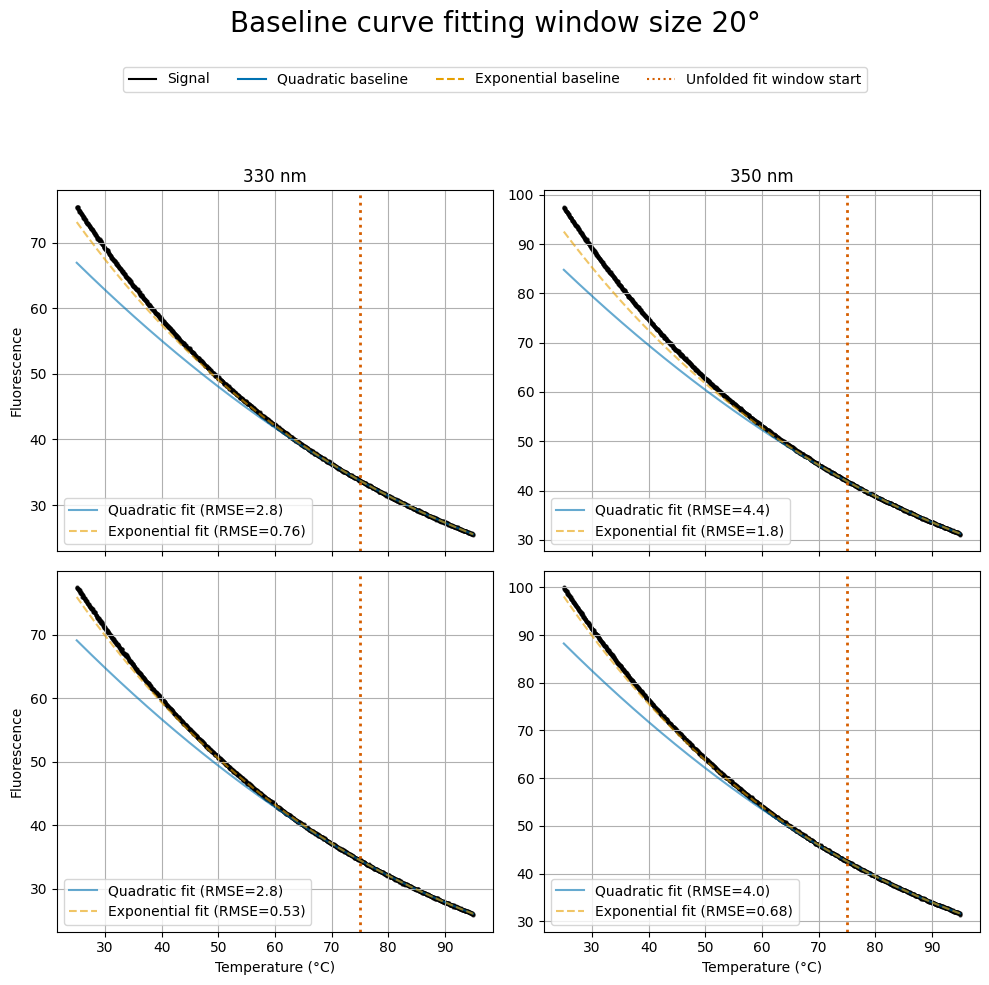

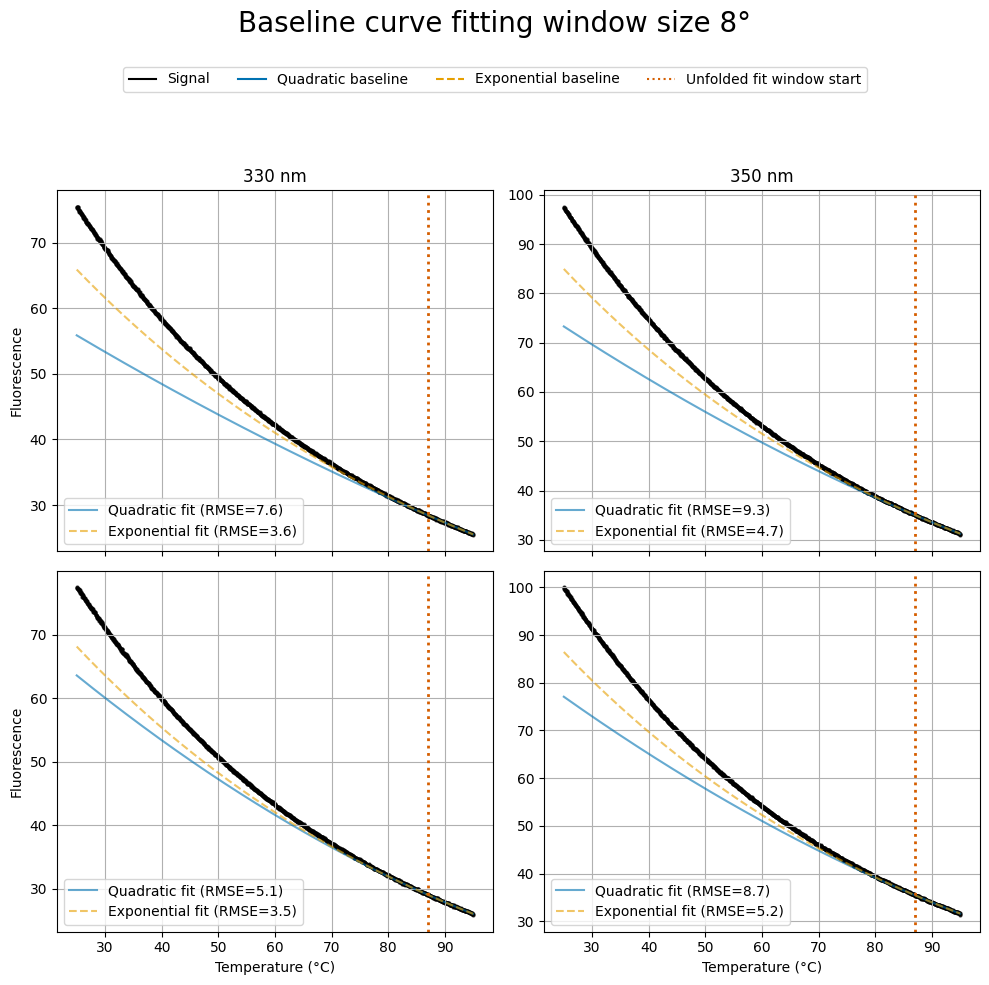

In [3]:
#comparing the fits using different window sizes

unfolded_comp(conditions, ws=20)

unfolded_comp(conditions, ws=8)


### Using a dataset containing curves for the ACBP dataset

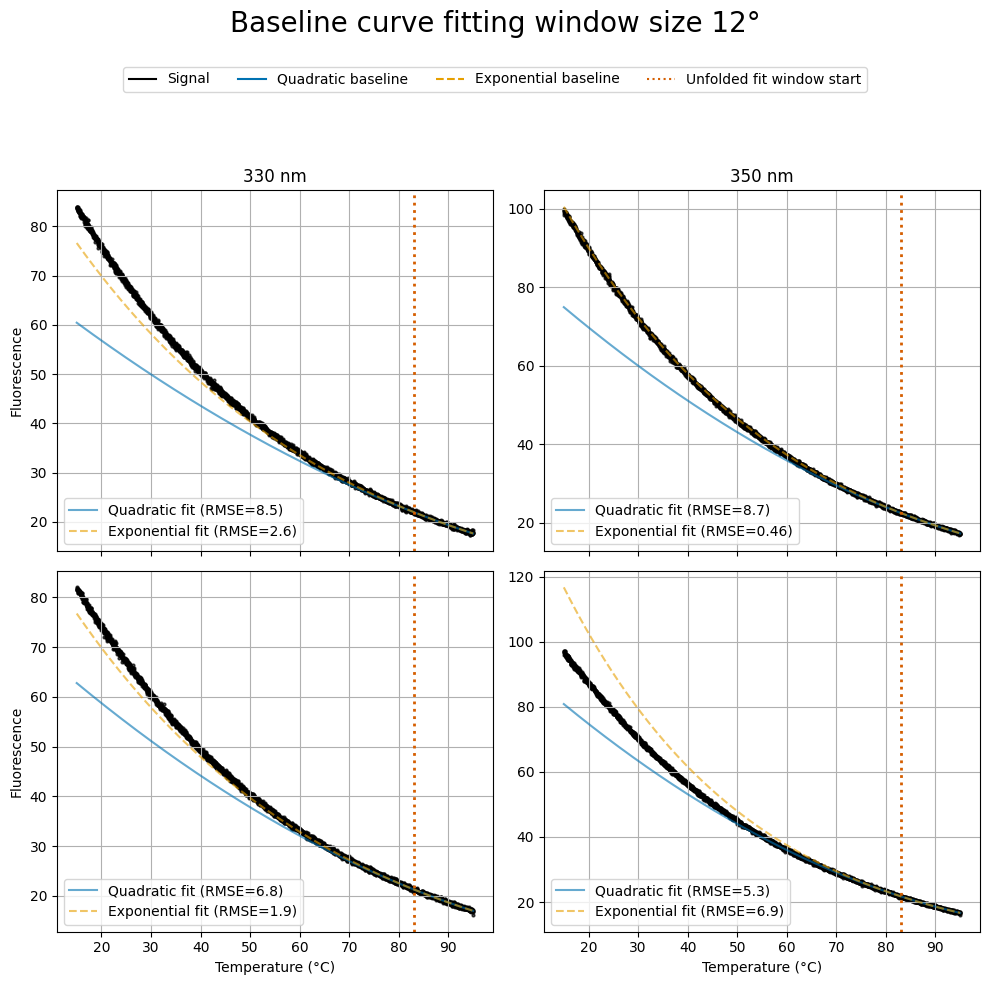

In [4]:
#using unfolded curves of the ACBP dataset

# selecting two curves with the highest denaturant concentration

conditions_nf = [True] * 2 + [False] * (16 - 2)

filename = "../data/20191202_ACBP_15C_95C_processed.xlsx"

# using the default window size

unfolded_comp(conditions_nf, filename)

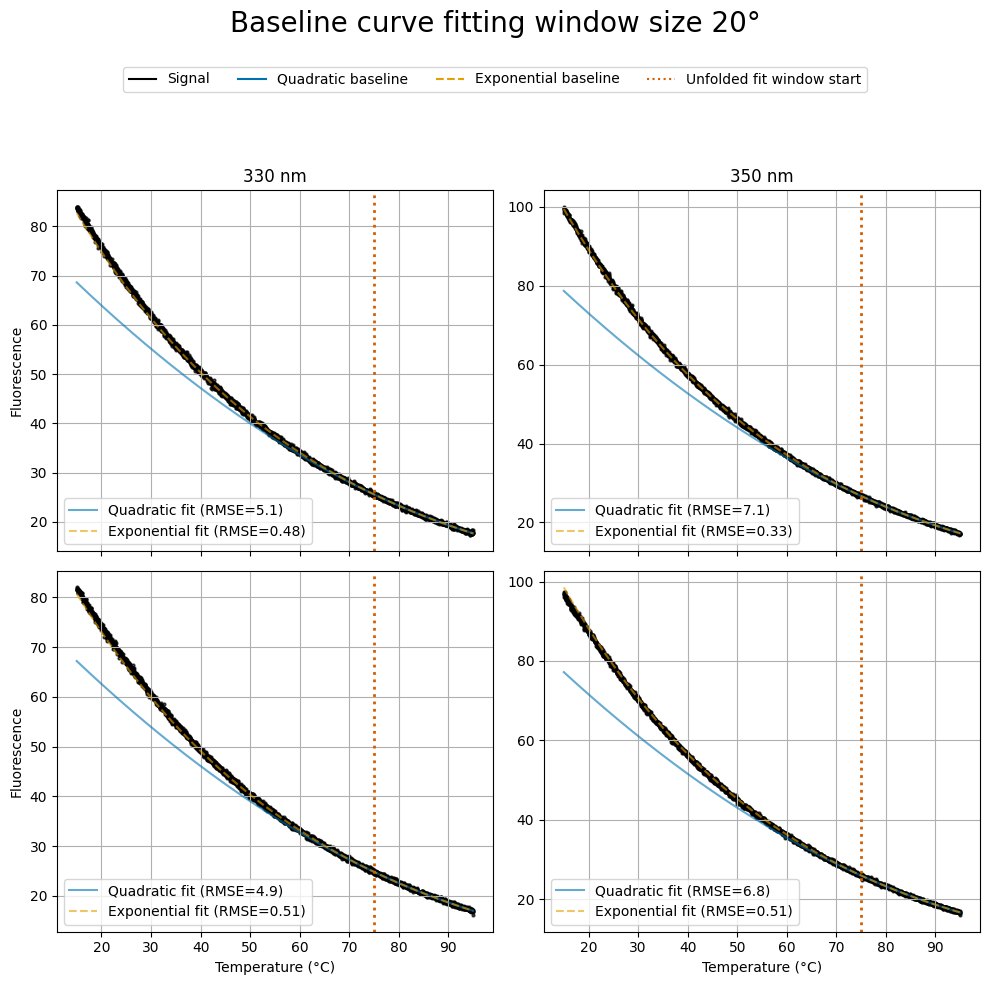

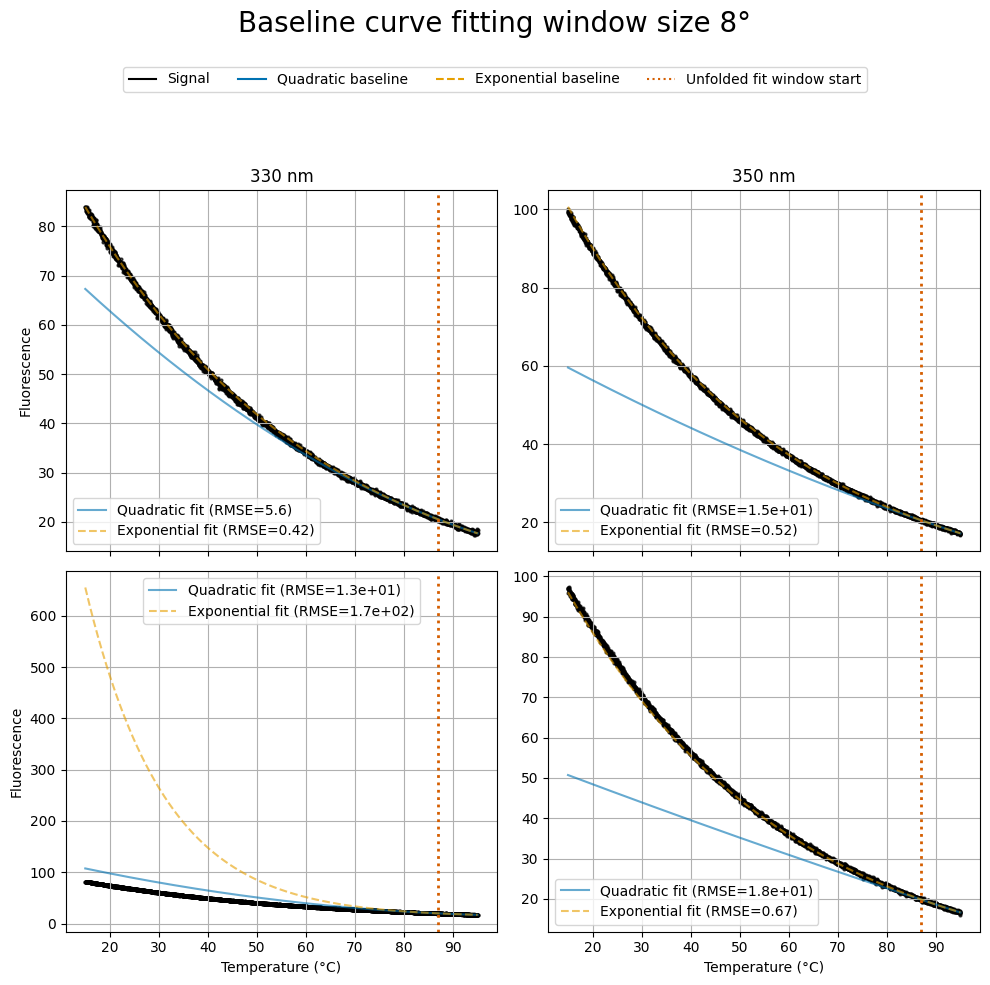

In [5]:
#comparing the fits using different window sizes

unfolded_comp(conditions_nf, filename, ws=20)

unfolded_comp(conditions_nf, filename, ws=8)



When choosing a formula, the exponential function models the unfolded baseline generally more accuratly than the quadratic function for 330nm and 350nm. However, the exponential function is more unstable with insufficient data while the quadratic function does not deviate as extremly so in cases with where only a limited unfolded state window is available caution is advised when using exponential.